In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class ParquetPacketDataset(Dataset):
    def __init__(self, file_paths, label_column='Label', transform=None, sample_fraction=0.5, include_labels=None):
        self.file_paths = file_paths
        self.label_column = label_column
        self.transform = transform
        self.sample_index = []
        self.partial_dataframes = []  # Hold partial sampled data to avoid reloading

        for file_idx, path in enumerate(file_paths):
            try:
                df = pd.read_parquet(path)
                if include_labels:
                    df = df[df[label_column].isin(include_labels)]
                    
                if len(df) == 0:
                    continue

                # Sample a fraction to avoid OOM
                df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
                self.partial_dataframes.append(df)
                self.sample_index.extend([(file_idx, i) for i in range(len(df))])
            except Exception as e:
                print(f"Error reading {path}: {e}")

        if not self.sample_index:
            raise ValueError("No samples collected. Check your parquet files or sample_fraction.")
        print(f"✅ Total samples collected: {len(self.sample_index)}")

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx):
        file_idx, row_idx = self.sample_index[idx]
        row = self.partial_dataframes[file_idx].iloc[row_idx]

        label = row[self.label_column]
        features = row.drop(self.label_column).values.astype('float32')
        features = torch.tensor(features)

        if self.transform:
            features = self.transform(features)

        # Convert label to 0 (benign) or 1 (anomaly)
        label_tensor = torch.tensor(0 if label == 'Benign' else 1, dtype=torch.long)

        return features, label_tensor


In [2]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
# List all parquet files
data_dir = 'archive'
parquet_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

train_dataset = ParquetPacketDataset(
    parquet_files,
    sample_fraction=1,
    include_labels=["Benign"]  # Train on only benign
)

test_dataset = ParquetPacketDataset(
    parquet_files,
    sample_fraction=0.25
)

def extract_features(dataset):
    features_list = []
    for i in range(len(dataset)):
        features, _ = dataset[i]
        features_list.append(features.numpy())
    return np.array(features_list)

X_train = extract_features(train_dataset)
scaler = StandardScaler()
scaler.fit(X_train)

def standardize_tensor(tensor):
    np_arr = tensor.numpy()
    scaled_arr = scaler.transform([np_arr])[0]
    return torch.tensor(scaled_arr, dtype=torch.float32)

train_dataset.transform = standardize_tensor
test_dataset.transform = standardize_tensor

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)


✅ Total samples collected: 97831
✅ Total samples collected: 107843


In [3]:
import joblib
joblib.dump(scaler, "trained_scaler.pkl")

['trained_scaler.pkl']

In [4]:
import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [5]:
import torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt

def evaluate_autoencoder(model, loader, device):
    model.eval()
    all_errors = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            errors = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)
            all_errors.extend(errors.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)

    return all_errors, all_labels

In [6]:
from sklearn.metrics import roc_auc_score

def plot_roc_auc(errors, labels):
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
    
    return thresholds, roc_auc


In [7]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def find_percentile_threshold(errors, labels, percentile=95):
    benign_errors = errors[labels == 0]  # Assuming 0 = benign
    threshold = np.percentile(benign_errors, percentile)
    return threshold

def find_best_threshold(errors, labels, fallback_percentile=95):
    # F1-optimal threshold
    precision, recall, thresholds = precision_recall_curve(labels, errors)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

    if len(thresholds) == 0:
        # fallback if thresholds are empty
        print("No thresholds found from PR curve, using fallback percentile.")
        return find_percentile_threshold(errors, labels, fallback_percentile)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Optional: check if threshold is too low (overfitting symptoms)
    if best_threshold < 0.001:
        print("F1-optimal threshold very low, switching to percentile-based.")
        return find_percentile_threshold(errors, labels, fallback_percentile)

    return best_threshold

def find_best_threshold_roc(errors, labels):
    fpr, tpr, thresholds = roc_curve(labels, errors)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

In [8]:
def plot_error_distribution(errors, labels, threshold):
    errors = np.array(errors)
    labels = np.array(labels)

    benign_errors = errors[labels == 0]
    anomalous_errors = errors[labels == 1]

    print("Benign samples:", len(benign_errors))
    print("Anomalous samples:", len(anomalous_errors))
    print(f"Threshold: {threshold:.5f}")

    plt.figure(figsize=(10, 5))
    plt.hist(benign_errors, bins=100, alpha=0.6, label='Benign', color='green')
    plt.hist(anomalous_errors, bins=100, alpha=0.6, label='Anomalous', color='orange')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.5f}')
    
    plt.yscale('log')
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Log Count")
    plt.title("Log-Scaled Histogram of Reconstruction Errors")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [9]:
def find_best_threshold_test(errors, labels):
    threshold_f1 = find_best_threshold(errors, labels)
    threshold_pct = find_percentile_threshold(errors, labels, 95)
    threshold_roc = find_best_threshold_roc(errors, labels)

    print("Threshold (F1):", threshold_f1)
    print("Threshold (95% benign):", threshold_pct)
    print("Threshold (ROC):", threshold_roc)

    best_threshold =  min(threshold_f1, threshold_pct, threshold_roc)
    return best_threshold


In [10]:
def evaluate_predictions(errors, labels, threshold):
    preds = (errors > threshold).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(labels, preds))

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Benign', 'Anomalous']))

    print("\nError Distribution")
    plot_error_distribution(errors, labels, threshold)

In [11]:
sample_input, _ = train_dataset[0]
input_dim = sample_input.shape[0]

base_model = SimpleAutoencoder(input_dim=input_dim)
base_model.load_state_dict(torch.load('simple_autoencoder.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
device='cuda' if torch.cuda.is_available() else 'cpu'

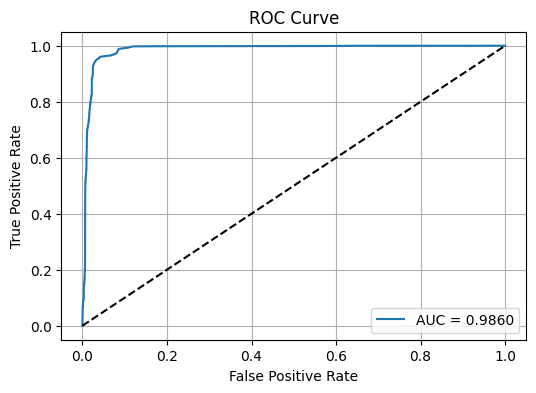

Threshold (F1): 0.020091595
Threshold (95% benign): 0.036792926
Threshold (ROC): 0.043680254
Best Threshold: 0.0201
Confusion Matrix:
[[22075  2181]
 [  872 82715]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.91      0.94     24256
   Anomalous       0.97      0.99      0.98     83587

    accuracy                           0.97    107843
   macro avg       0.97      0.95      0.96    107843
weighted avg       0.97      0.97      0.97    107843


Error Distribution
Benign samples: 24256
Anomalous samples: 83587
Threshold: 0.02009


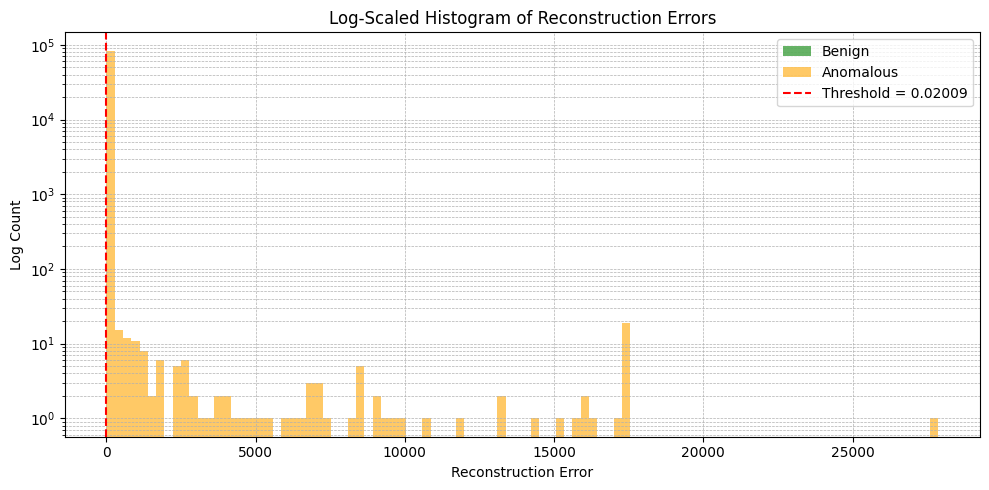

In [13]:
# Evaluate
errors, labels = evaluate_autoencoder(base_model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Find best threshold and show ROC/AUC
thresholds, roc_auc = plot_roc_auc(errors, labels)
best_threshold = find_best_threshold_test(errors, labels)
print(f"Best Threshold: {best_threshold:.4f}")

# Evaluate at best threshold
evaluate_predictions(errors, labels, best_threshold)


In [14]:
import torch
import torch.nn.functional as F

def compute_reconstruction_error(model, sample, device):
    model.eval()
    sample = sample.to(device).unsqueeze(0)  # Add batch dim
    with torch.no_grad():
        output = model(sample)
        error = F.mse_loss(output, sample, reduction='mean')  # Scalar error
    return error.item()

# Example usage
sample_row = 79
sample_tensor = test_dataset[sample_row][0]  # Get the first sample, ignore label
print(f"Actual Label: {"Benign" if test_dataset[sample_row][1] == 0 else "Anomalous"}")
recon_error = compute_reconstruction_error(base_model, sample_tensor, device)

if recon_error > best_threshold:
    print(f"Anomaly Detected! Error = {recon_error:.5f}")
else:
    print(f"Benign Sample. Error = {recon_error:.5f}")


Actual Label: Anomalous
Anomaly Detected! Error = 6.33028
